# Data Analysis of past Loans 
## Supervised learning with Machine Learning algorithms

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

# Data acquisition  <a name="Data acquisition"></a>

#  Data sources

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Let's download the dataset

In [2]:
#!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


#  Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Let's plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

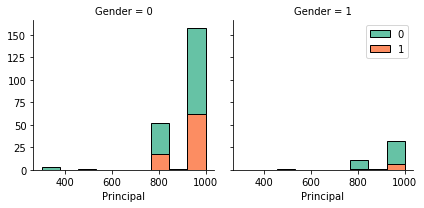

In [30]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set2", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

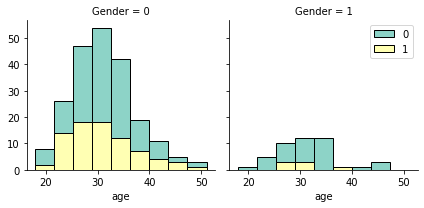

In [31]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set3", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

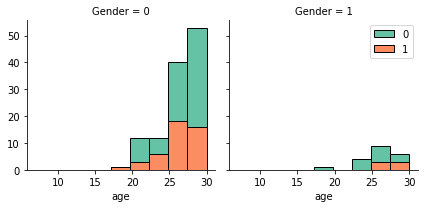

In [32]:
bins = np.linspace(df.terms.min(), df.terms.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set2", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

#  Feature selection/extraction

# Let's look at the day of the week people get the loan 

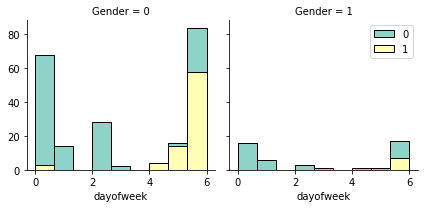

In [33]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set3", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold values less then day 4.   
Ps: After analysing the file loan_test.csv, we see that we could change the threshold values less then day 6. 

In [12]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>5)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,0
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,0


Convert Categorical features to numerical values

Lets look at gender:

In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay their loans while only 73 % of males pay their loan


Let's convert male to 0 and female to 1:


In [14]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,0
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,0


Ps: Here it was included the binarization convertion: PAIDOFF to 0 and COLLECTION to 1:

In [15]:
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,0,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,0,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,0,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,0,1000,30,2016-09-09,2016-10-08,28,college,1,4,0
4,6,6,0,1000,30,2016-09-09,2016-10-08,29,college,0,4,0


 One Hot Encoding  
 How about education?

In [16]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              0              0.750000
                      1              0.250000
High School or Below  0              0.741722
                      1              0.258278
Master or Above       0              0.500000
                      1              0.500000
college               0              0.765101
                      1              0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [17]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical variables to binary variables and append them to the feature Data Frame 

In [18]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,0,0,0,1
4,1000,30,29,0,0,0,0,1


#  Feature selection

Lets defined feature sets, X:

In [19]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,0,0,0,1
4,1000,30,29,0,0,0,0,1


What are our lables?

In [20]:
y = df['loan_status'].values
y[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

# Normalize Data 

Data Standartization give data zero mean and unit variance (technically should be done after train test split )

In [21]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -0.96032402,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -0.96032402,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -0.96032402,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177, -0.96032402,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004, -0.96032402,
        -0.38170062, -0.87997669,  1.14984679]])

# Exploratory Data Analysis

#  K Nearest Neighbor(KNN)


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [23]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=3)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (242, 8) (242,)
Test set: (104, 8) (104,)


In [24]:
X_train= preprocessing.StandardScaler().fit(X_train).transform(X_train)

In [25]:
Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfusionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    nkk = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat1=nkk.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat1)

    
    std_acc[n-1]=np.std(yhat1==y_test)/np.sqrt(yhat1.shape[0])

mean_acc

array([0.63461538, 0.70192308, 0.64423077, 0.67307692, 0.63461538,
       0.70192308, 0.68269231, 0.69230769, 0.65384615, 0.70192308,
       0.68269231, 0.70192308, 0.69230769, 0.71153846])

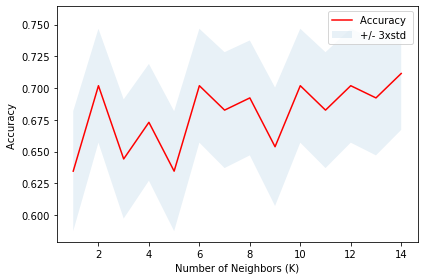

In [35]:
plt.plot(range(1,Ks),mean_acc,'r')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [27]:
k = 11
#Train Model and Predict  
knn = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

In [28]:
#Accuracy for the trainset
print('Train set Accuracy KNN: ', metrics.accuracy_score(y_train, knn.predict(X_train)))

Train set Accuracy KNN:  0.768595041322314


#  Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree # it shows the default parameters

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [30]:
dt = loanTree.fit(X_train,y_train)

In [31]:
#Accuracy for the trainset
print('Train set Accuracy Decision Tree: ', metrics.accuracy_score(y_train, dt.predict(X_train)))

Train set Accuracy Decision Tree:  0.7933884297520661


# Support Vector Machine

In [32]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
vm = clf.fit(X_train, y_train) 

In [33]:
#Accuracy for the trainset
print('Train set Accuracy SVM: ', metrics.accuracy_score(y_train, vm.predict(X_train)))

Train set Accuracy SVM:  0.7892561983471075


# Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
#Accuracy for the trainset
print('Train set Accuracy Logistic Regression: ', metrics.accuracy_score(y_train, LR.predict(X_train)))

Train set Accuracy Logistic Regression:  0.7644628099173554


# Model Evaluation using Test set

In [36]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [37]:
#!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

Load Test set for evaluation 

In [39]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [39]:
test_df.shape

(54, 10)

# Convert to date time object 

In [40]:
test_df['due_date'] = pd.to_datetime(df['due_date'])
test_df['effective_date'] = pd.to_datetime(df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-08,2016-10-07,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-08,2016-09-22,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-09,2016-10-08,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-09,2016-10-08,29,Bechalor,male


# Data visualization and pre-processing

Let’s see how many of each class is in our data set 

In [41]:
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

40 people have paid off the loan on time while 14 have gone into collection 

Let's plot some columns to underestand data better:

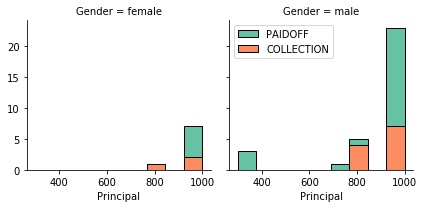

In [40]:
import seaborn as sns

bins = np.linspace(test_df.Principal.min(), test_df.Principal.max(), 10)
g = sns.FacetGrid(test_df, col="Gender", hue="loan_status", palette="Set2", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

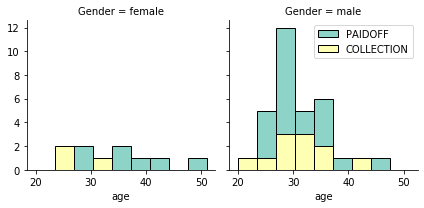

In [41]:
bins = np.linspace(test_df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(test_df, col="Gender", hue="loan_status", palette="Set3", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

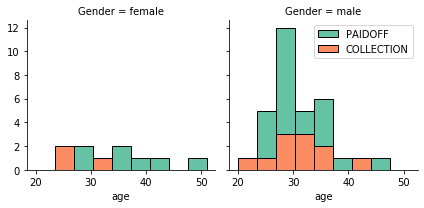

In [52]:
bins = np.linspace(test_df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(test_df, col="Gender", hue="loan_status", palette="Set2", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

In [45]:
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>5)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-08,2016-10-07,35,Master or Above,male,3,0
2,21,21,PAIDOFF,1000,30,2016-09-08,2016-09-22,43,High School or Below,female,3,0
3,24,24,PAIDOFF,1000,30,2016-09-09,2016-10-08,26,college,male,4,0
4,35,35,PAIDOFF,800,15,2016-09-09,2016-10-08,29,Bechalor,male,4,0


Convert Categorical features to numerical values

Let's convert categorical features "Gender"  and "loan_status" to numerical values:

In [46]:
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.727273
        COLLECTION     0.272727
male    PAIDOFF        0.744186
        COLLECTION     0.255814
Name: loan_status, dtype: float64

In [47]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-08,2016-10-07,35,Master or Above,0,3,0
2,21,21,PAIDOFF,1000,30,2016-09-08,2016-09-22,43,High School or Below,1,3,0
3,24,24,PAIDOFF,1000,30,2016-09-09,2016-10-08,26,college,0,4,0
4,35,35,PAIDOFF,800,15,2016-09-09,2016-10-08,29,Bechalor,0,4,0


In [48]:
test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,0,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,0,300,7,2016-09-08,2016-10-07,35,Master or Above,0,3,0
2,21,21,0,1000,30,2016-09-08,2016-09-22,43,High School or Below,1,3,0
3,24,24,0,1000,30,2016-09-09,2016-10-08,26,college,0,4,0
4,35,35,0,800,15,2016-09-09,2016-10-08,29,Bechalor,0,4,0


To convert the categorical Feature "education" we use the groupby operation, " `.groupby()` ", that involves some combination of splitting the object, applying a function, and combining the results. And the operation " `.value_counts()` " return a serie containing counts of unique values.

In [49]:
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              0              1.000000
High School or Below  0              0.523810
                      1              0.476190
Master or Above       0              1.000000
college               0              0.826087
                      1              0.173913
Name: loan_status, dtype: float64

In [50]:
test_df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,50,1,Bechalor
1,300,7,35,0,Master or Above
2,1000,30,43,1,High School or Below
3,1000,30,26,0,college
4,800,15,29,0,Bechalor


#### Use one hot encoding technique to conver categorical variables to binary variables and append them to the feature Data Frame

In [51]:
Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,0,0,0,0
2,1000,30,43,1,0,0,1,0
3,1000,30,26,0,0,0,0,1
4,800,15,29,0,0,1,0,0


# Feature selection

In [52]:
X_test = Feature
X_test[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,0,0,0,0
2,1000,30,43,1,0,0,1,0
3,1000,30,26,0,0,0,0,1
4,800,15,29,0,0,1,0,0


In [53]:
y_test = test_df['loan_status'].values
y_test[0:5]

array([0, 0, 0, 0, 0])

#  Normalize Data 

Data Standartization give data zero mean and unit variance (technically should be done after train test split )

In [54]:
X_test= preprocessing.StandardScaler().fit(X_test).transform(X_test)
X_test[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.11803399,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054, -1.11803399,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211, -1.11803399,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054, -1.11803399,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054, -1.11803399,
         2.39791576, -0.79772404, -0.86135677]])

## Prediction and Evaluation 

#### KNN

In [55]:
#Prediction
yhat1 = knn.predict(X_test)
#Evaluation
print("Test set Accuracy for KNN:", metrics.accuracy_score(y_test, yhat1))

Test set Accuracy for KNN: 0.7777777777777778


In [56]:
print("Jaccard score for KNN: %.4f" % jaccard_similarity_score(y_test, yhat1))
print("Avg F1-score for KNN: %.4f" % f1_score(y_test, yhat1, average='weighted'))

Jaccard score for KNN: 0.7778
Avg F1-score for KNN: 0.7284


/home/fernanda/anaconda2/envs/gogame/lib/python3.6/site-packages/sklearn/metrics/_classification.py:660: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


#### Decision Tree

In [57]:
#Prediction
predTree = loanTree.predict(X_test)
print("Test set Accuracy for Decision Tree: ", metrics.accuracy_score(y_test, predTree))

Test set Accuracy for Decision Tree:  0.8333333333333334


In [58]:
print("Jaccard score for Decision Tree: %.4f" % jaccard_similarity_score(y_test, predTree))
print("Avg F1-score for Decision Tree: %.4f" % f1_score(y_test, predTree, average='weighted'))

Jaccard score for Decision Tree: 0.8333
Avg F1-score for Decision Tree: 0.8313


/home/fernanda/anaconda2/envs/gogame/lib/python3.6/site-packages/sklearn/metrics/_classification.py:660: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


#### SVM

In [59]:
yhat3 = clf.predict(X_test)
print("Test set Accuracy SVM: ", metrics.accuracy_score(y_test, yhat3))

Test set Accuracy SVM:  0.8148148148148148


In [60]:
print("Jaccard score for SVM: %.4f" % jaccard_similarity_score(y_test, yhat3))
print("Avg F1-score for SVM: %.4f" % f1_score(y_test, yhat3, average='weighted'))

Jaccard score for SVM: 0.8148
Avg F1-score for SVM: 0.8038


/home/fernanda/anaconda2/envs/gogame/lib/python3.6/site-packages/sklearn/metrics/_classification.py:660: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


#### Logistic Regression

In [61]:
yhat4 = LR.predict(X_test)
yhat4_prob = LR.predict_proba(X_test)
print("Test set Accuracy Logistic Regression: ", metrics.accuracy_score(y_test, yhat4))

Test set Accuracy Logistic Regression:  0.7592592592592593


In [62]:
print("Jaccard score for Logistic Regression: %.4f" % jaccard_similarity_score(y_test, yhat4))
print("Avg F1-score for Logistic Regression: %.4f" % f1_score(y_test, yhat4, average='weighted'))

Jaccard score for Logistic Regression: 0.7593
Avg F1-score for Logistic Regression: 0.6718


/home/fernanda/anaconda2/envs/gogame/lib/python3.6/site-packages/sklearn/metrics/_classification.py:660: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [63]:
from sklearn.metrics import log_loss
LR2 = LogisticRegression(C=0.01, solver='sag').fit(X,y)

yhat_prob2 = LR2.predict_proba(X_test)
print ("LogLoss for Logistic Regression: : %.2f" % log_loss(y_test, yhat_prob2))

LogLoss for Logistic Regression: : 0.51


# Final Report
## Classification algorithms in Machine Learning


| Algorithm           | Jaccard | F1-score | LogLoss |
|-------------------- |---------|----------|---------|
| KNN                 | 0.7778       | 0.7284        | NA      |
| Decision Tree       | 0.8333       | 0.8313        | NA      |
| SVM                 | 0.8148       | 0.8038        | NA      |
| Logistic Regression | 0.7593       | 0.6718        | 0.51    |